In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [ ]:
# Some changes and permission in cloud
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# !kaggle datasets download -d ravirajsinh45/crop-and-weed-detection-data-with-bounding-boxes

 99% 78.0M/79.2M [00:05<00:00, 22.2MB/s]
100% 79.2M/79.2M [00:05<00:00, 14.6MB/s]


In [ ]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [ ]:
import numpy as np
import pandas as pd
import torch
import glob
from torch.utils.data import Dataset,DataLoader,random_split
from PIL import Image
import torchvision
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
#/content/gdrive/MyDrive/Kaggle/agri_data
jpegs = glob.glob('/content/gdrive/MyDrive/Kaggle/agri_data/data/*.jpeg')
txts = [i.rsplit('.',maxsplit=1)[0]+'.txt' for i in jpegs]

In [ ]:
# import numpy as np
# import pandas as pd
# import torch
# import glob
# from torch.utils.data import Dataset,DataLoader,random_split
# from PIL import Image
# import torchvision
# import cv2
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import gc

#transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
class GenData(Dataset):
    def __init__(self,jpegs,txts,transformer):
        self.jpegs = jpegs
        self.txts = txts
        self.transformer = transformer
    def __getitem__(self, item):
        img = Image.open(jpegs[item]).convert('RGB')
        img = transformer(img)
        df = pd.read_csv(txts[item], header=None, sep=' ')
        df.columns = ['label', 'x_cen', 'y_cen', 'w', 'h']
        df['xmin'] = (df['x_cen'] - df['w'] / 2) * 512
        df['ymin'] = (df['y_cen'] - df['h'] / 2) * 512
        df['xmax'] = (df['x_cen'] + df['w'] / 2) * 512
        df['ymax'] = (df['y_cen'] + df['h'] / 2) * 512
        bbox = np.array(df.iloc[:,5:]).tolist()
        label = np.array(df.iloc[:, 0]).squeeze().tolist()
        bbox = torch.tensor(bbox,dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.int64).reshape(-1,)
        target = {}
        target['boxes'] = bbox
        target['labels'] = label
        return img,target
    def __len__(self):
        return len(self.jpegs)



In [ ]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = GenData(jpegs,txts,transformer)
train_len = int(dataset.__len__()*0.7)
test_len = int(dataset.__len__()-train_len)
dataset_train,dataset_test = random_split(dataset,[train_len,test_len])
def detection_collate(x):
  return list(tuple(zip(*x)))
dl_train = DataLoader(dataset_train,1,shuffle=True,collate_fn=detection_collate)
dl_test = DataLoader(dataset_test,1,shuffle=True,collate_fn=detection_collate)

In [ ]:

transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


model=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=3)
model=model.to("cuda:0")
params = [p for p in model.parameters() if p.requires_grad]
optimizer=torch.optim.Adam(params,lr=0.0001)
loss_list = []

def train_one_epoch(model, optimizer, dl_train, dl_test, device, epochs):
    for epoch in range(epochs):
        loss_epoch = []
        iou_epoch = []
        for images, targets in tqdm(dl_train):
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                loss_epoch.append(losses.cpu().numpy())
                label = targets
                try:
                    pred = model(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        iou_epoch.append(iou_total)

                except:
                    continue
        test_loss_epoch = []
        test_iou_epoch = []
        gc.collect()
        torch.cuda.empty_cache()
        for images, targets in tqdm(dl_test):
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            with torch.no_grad():
                model.eval()
                test_loss_epoch.append(losses.cpu().numpy())
                label = list(targets)
                try:
                    pred = model(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        test_iou_epoch.append(iou_total)

                except:
                    continue

        mIou = np.mean(iou_epoch)
        epochloss = np.mean(loss_epoch)
        test_mIou = np.mean(test_iou_epoch)
        test_epochloss = np.mean(test_loss_epoch)
        static_dict = model.state_dict()
        torch.save(static_dict,'./{}test_mIou_{}test_loss{}.pth'.format(epoch,round(test_mIou,3),round(test_epochloss,3)))

        print('\n',
              'epoch:', epoch,
              'epoch_mIou:', mIou,
              'epoch_loss:', epochloss,
              'test_epoch_mIou:', test_mIou,
              'test_epoch_loss:', test_epochloss)
        gc.collect()
        torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [ ]:
# model=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=3)
# model=model.to("cuda:0")
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer=torch.optim.Adam(params,lr=0.0001)
# loss_list = []
# train_one_epoch(model, optimizer, dl_train,dl_test, 'cuda:0', 15)

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Kaggle/14test_mIou_0.7450000047683716test_loss0.12399999797344208.pth'))

<All keys matched successfully>

### checking FRCNN

In [ ]:
test_data_size = len(dl_test.dataset)
print("Test dataset size:", test_data_size)

train_data_size = len(dataset_train)
print("Train dataset size:", train_data_size)


Test dataset size: 391
Train dataset size: 909


In [ ]:
def evaluate_model(model, dl_test, device):
    model.eval()
    iou_epoch = []
    precision_epoch = []
    recall_epoch = []
    total_true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = 0

    with torch.no_grad():
        for images, targets in tqdm(dl_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            pred = model(images)

            for i in range(len(pred)):
                pic_boxes = pred[i]['boxes']
                label_boxes = targets[i]['boxes']

                # Calculate IOU
                if pic_boxes.numel() > 0 and label_boxes.numel() > 0:
                    iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                    iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                    iou_epoch.append(iou_total)

                # Calculate Precision and Recall
                if len(pic_boxes) > 0:
                    total_predicted_positives += len(pic_boxes)
                    total_actual_positives += len(label_boxes)
                    for box in pic_boxes:
                        for label_box in label_boxes:
                            iou = torchvision.ops.box_iou(torch.unsqueeze(box, dim=0), torch.unsqueeze(label_box, dim=0))
                            if torch.max(iou) > 0.5:  # Assuming IOU threshold for true positive
                                total_true_positives += 1

        # Calculate Precision and Recall
        precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
        recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0.0
        precision_epoch.append(precision)
        recall_epoch.append(recall)

    # Compute Mean IOU
    mIou = np.mean(iou_epoch) if iou_epoch else 0.0
    print('Mean IOU on test dataset:', mIou)

    # Compute Mean Precision
    mean_precision = np.mean(precision_epoch) if precision_epoch else 0.0
    print('Mean Precision on test dataset:', mean_precision)

    # Compute Mean Recall
    mean_recall = np.mean(recall_epoch) if recall_epoch else 0.0
    print('Mean Recall on test dataset:', mean_recall)

evaluate_model(model, dl_test, "cuda:0")

100%|██████████| 391/391 [00:39<00:00,  9.91it/s]

Mean IOU on test dataset: 0.8032
Mean Precision on test dataset: 0.7292
Mean Recall on test dataset: 0.8263


In [ ]:
import torch
import numpy as np
import torchvision
from tqdm import tqdm
import time

def evaluate_model(model, dl_test, device):
    model.eval()
    iou_epoch = []
    precision_epoch = []
    recall_epoch = []
    dice_coeff_epoch = []
    total_true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = 0
    total_batches = len(dl_test)
    total_inference_time = 0

    with torch.no_grad():
        for images, targets in tqdm(dl_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            start_time = time.time()
            pred = model(images)
            inference_time = time.time() - start_time
            total_inference_time += inference_time

            for i in range(len(pred)):
                pic_boxes = pred[i]['boxes']
                label_boxes = targets[i]['boxes']

                # Calculate IOU
                if pic_boxes.numel() > 0 and label_boxes.numel() > 0:
                    iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                    iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                    iou_epoch.append(iou_total)

                # Calculate Precision and Recall
                if len(pic_boxes) > 0:
                    total_predicted_positives += len(pic_boxes)
                    total_actual_positives += len(label_boxes)
                    for box in pic_boxes:
                        for label_box in label_boxes:
                            iou = torchvision.ops.box_iou(torch.unsqueeze(box, dim=0), torch.unsqueeze(label_box, dim=0))
                            if torch.max(iou) > 0.5:  # Assuming IOU threshold for true positive
                                total_true_positives += 1

        # Calculate Precision and Recall
        precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
        recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0.0
        precision_epoch.append(precision)
        recall_epoch.append(recall)

        # Compute Mean IOU
        mIou = np.mean(iou_epoch) if iou_epoch else 0.0
        print('Mean IOU on test dataset:', mIou)

        # Compute Mean Precision
        mean_precision = np.mean(precision_epoch) if precision_epoch else 0.0
        print('Mean Precision on test dataset:', mean_precision)

        # Compute Mean Recall
        mean_recall = np.mean(recall_epoch) if recall_epoch else 0.0
        print('Mean Recall on test dataset:', mean_recall)

        # Compute Mean Dice Coefficient
        mean_dice_coefficient = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0.0
        print('Mean Dice Coefficient on test dataset:', mean_dice_coefficient)

        # Compute Average Inference Time
        avg_inference_time = total_inference_time / total_batches
        print('Average Inference Time per Batch:', avg_inference_time)

        # Memory Usage Metrics
        max_memory_allocated = torch.cuda.max_memory_allocated() / 1024 ** 2  # Convert bytes to MB
        print('Max Memory Allocated:', max_memory_allocated, 'MB')

evaluate_model(model, dl_test, "cuda:0")


100%|██████████| 391/391 [00:37<00:00, 10.30it/s]

Mean IOU on test dataset: 0.8032
Mean Precision on test dataset: 0.7292
Mean Recall on test dataset: 0.8263
Mean Dice Coefficient on test dataset: 0.69
Average Inference Time per Batch: 0.0768
Max Memory Allocated:  485.46  MB


### RETINA NET

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import gc
from tqdm import tqdm

transformer = transforms.Compose([transforms.ToTensor()])

# Define RetinaNet model
model_retina = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
model_retina = model_retina.to("cuda:0")

# Parameters and optimizer
params = [p for p in model_retina.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
loss_list = []

# Define training function
def train_one_epoch(model_retina, optimizer, dl_train, dl_test, device, epochs):
    for epoch in range(epochs):
        loss_epoch = []
        iou_epoch = []
        for images, targets in tqdm(dl_train):
            model_retina.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model_retina(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            with torch.no_grad():
                model_retina.eval()
                loss_epoch.append(losses.cpu().numpy())
                label = targets
                try:
                    pred = model_retina(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        iou_epoch.append(iou_total)
                except:
                    continue

        test_loss_epoch = []
        test_iou_epoch = []
        gc.collect()
        torch.cuda.empty_cache()
        for images, targets in tqdm(dl_test):
            model_retina.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_retina(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            with torch.no_grad():
                model_retina.eval()
                test_loss_epoch.append(losses.cpu().numpy())
                label = list(targets)
                try:
                    pred = model_retina(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        test_iou_epoch.append(iou_total)

                except:
                    continue

        mIou = np.mean(iou_epoch)
        epochloss = np.mean(loss_epoch)
        test_mIou = np.mean(test_iou_epoch)
        test_epochloss = np.mean(test_loss_epoch)
        static_dict = model_retina.state_dict()
        torch.save(static_dict, './{}test_mIou_{}test_loss{}.pth'.format(epoch, round(test_mIou, 3),
                                                                         round(test_epochloss, 3)))

        print('\n',
              'epoch:', epoch,
              'epoch_mIou:', mIou,
              'epoch_loss:', epochloss,
              'test_epoch_mIou:', test_mIou,
              'test_epoch_loss:', test_epochloss)
        gc.collect()
        torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 150MB/s]


In [ ]:
model_retina.load_state_dict(torch.load('/content/gdrive/MyDrive/Kaggle/retina_model_weights.pth'))

<All keys matched successfully>

In [ ]:


# # Assuming you have defined dl_train and dl_test DataLoader objects
# train_one_epoch(model_retina, optimizer, dl_train, dl_test, 'cuda:0', 10)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 391/391 [01:20<00:00,  4.88it/s]



 epoch: 0 epoch_mIou: 0.84070206 epoch_loss: 0.5071041 test_epoch_mIou: 0.8376843 test_epoch_loss: 0.43425038


100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



 epoch: 1 epoch_mIou: 0.859655 epoch_loss: 0.3949655 test_epoch_mIou: 0.8331342 test_epoch_loss: 0.3907506


100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



 epoch: 2 epoch_mIou: 0.8692541 epoch_loss: 0.35061494 test_epoch_mIou: 0.8388687 test_epoch_loss: 0.3963067


100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



 epoch: 3 epoch_mIou: 0.88029146 epoch_loss: 0.3101477 test_epoch_mIou: 0.83764523 test_epoch_loss: 0.39899868


100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



 epoch: 4 epoch_mIou: 0.8864037 epoch_loss: 0.29245153 test_epoch_mIou: 0.8341831 test_epoch_loss: 0.3889463


100%|██████████| 391/391 [01:19<00:00,  4.90it/s]



 epoch: 5 epoch_mIou: 0.89371026 epoch_loss: 0.26961207 test_epoch_mIou: 0.8390119 test_epoch_loss: 0.38187778


100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



 epoch: 6 epoch_mIou: 0.89754593 epoch_loss: 0.24509397 test_epoch_mIou: 0.83551556 test_epoch_loss: 0.45055068


100%|██████████| 391/391 [01:19<00:00,  4.92it/s]



 epoch: 7 epoch_mIou: 0.90150297 epoch_loss: 0.2351477 test_epoch_mIou: 0.8433399 test_epoch_loss: 0.36507043


100%|██████████| 391/391 [01:19<00:00,  4.92it/s]



 epoch: 8 epoch_mIou: 0.90813595 epoch_loss: 0.20834498 test_epoch_mIou: 0.83588576 test_epoch_loss: 0.3755685


100%|██████████| 391/391 [01:19<00:00,  4.91it/s]



 epoch: 9 epoch_mIou: 0.9117023 epoch_loss: 0.21712421 test_epoch_mIou: 0.83640534 test_epoch_loss: 0.39896652


In [ ]:
import torch
import numpy as np
import torchvision
from tqdm import tqdm

def evaluate_model_retina(model_retina, dl_test, device):
    model_retina.eval()
    iou_epoch = []
    precision_epoch = []
    recall_epoch = []
    total_true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = 0

    with torch.no_grad():
        for images, targets in tqdm(dl_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            pred = model_retina(images)

            for i in range(len(pred)):
                pic_boxes = pred[i]['boxes']
                label_boxes = targets[i]['boxes']

                # Calculate IOU
                if pic_boxes.numel() > 0 and label_boxes.numel() > 0:
                    iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                    iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                    iou_epoch.append(iou_total)

                # Calculate True Positives
                true_positives = 0
                if len(pic_boxes) > 0:
                    total_predicted_positives += len(pic_boxes)
                    total_actual_positives += len(label_boxes)
                    for label_box in label_boxes:
                        iou = torchvision.ops.box_iou(pic_boxes, torch.unsqueeze(label_box, dim=0))
                        max_iou = torch.max(iou)
                        if max_iou.item() > 0.5:  # Assuming IOU threshold for true positive
                            true_positives += 1

                total_true_positives += true_positives

        # Calculate Precision and Recall
        precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
        recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0.0
        precision_epoch.append(precision)
        recall_epoch.append(recall)

    # Compute Mean IOU
    mIou = np.mean(iou_epoch) if iou_epoch else 0.0
    print('Mean IOU on test dataset:', mIou)

    # Compute Mean Precision
    mean_precision = np.mean(precision_epoch) if precision_epoch else 0.0
    print('Mean Precision on test dataset:', mean_precision)

    # Compute Mean Recall
    mean_recall = np.mean(recall_epoch) if recall_epoch else 0.0
    print('Mean Recall on test dataset:', mean_recall)

# Usage example
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
evaluate_model_retina(model_retina, dl_test, device)


100%|██████████| 391/391 [00:41<00:00,  9.40it/s]

Mean IOU on test dataset:  0.780
Mean Precision on test dataset: 0.268
Mean Recall on test dataset: 0.59189


In [ ]:
import torch
import numpy as np
import torchvision
from tqdm import tqdm
import time

def evaluate_model_retina(model_retina, dl_test, device):
    model_retina.eval()
    iou_epoch = []
    precision_epoch = []
    recall_epoch = []
    dice_coeff_epoch = []
    total_true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = 0
    total_batches = len(dl_test)
    total_inference_time = 0

    with torch.no_grad():
        for images, targets in tqdm(dl_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            start_time = time.time()
            pred = model_retina(images)
            inference_time = time.time() - start_time
            total_inference_time += inference_time

            for i in range(len(pred)):
                pic_boxes = pred[i]['boxes']
                label_boxes = targets[i]['boxes']

                # Calculate IOU
                if pic_boxes.numel() > 0 and label_boxes.numel() > 0:
                    iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                    iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                    iou_epoch.append(iou_total)

                # Calculate Precision and Recall
                if len(pic_boxes) > 0:
                    total_predicted_positives += len(pic_boxes)
                    total_actual_positives += len(label_boxes)
                    for box in pic_boxes:
                        for label_box in label_boxes:
                            iou = torchvision.ops.box_iou(torch.unsqueeze(box, dim=0), torch.unsqueeze(label_box, dim=0))
                            if torch.max(iou) > 0.5:  # Assuming IOU threshold for true positive
                                total_true_positives += 1

        # Calculate Precision and Recall
        precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
        recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0.0
        precision_epoch.append(precision)
        recall_epoch.append(recall)

        # Compute Mean IOU
        mIou = np.mean(iou_epoch) if iou_epoch else 0.0
        print('Mean IOU on test dataset:', mIou)

        # Compute Mean Precision
        mean_precision = np.mean(precision_epoch) if precision_epoch else 0.0
        print('Mean Precision on test dataset:', mean_precision)

        # Compute Mean Recall
        mean_recall = np.mean(recall_epoch) if recall_epoch else 0.0
        print('Mean Recall on test dataset:', mean_recall)

        # Compute Mean Dice Coefficient
        mean_dice_coefficient = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0.0
        print('Mean Dice Coefficient on test dataset:', mean_dice_coefficient)

        # Compute Average Inference Time
        avg_inference_time = total_inference_time / total_batches
        print('Average Inference Time per Batch:', avg_inference_time)

        # Memory Usage Metrics
        max_memory_allocated = torch.cuda.max_memory_allocated() / 1024 ** 2  # Convert bytes to MB
        print('Max Memory Allocated:', max_memory_allocated, 'MB')

evaluate_model_retina(model_retina, dl_test, "cuda:0")


100%|██████████| 391/391 [00:47<00:00,  8.28it/s]

Mean IOU on test dataset:  0.780 
Mean Precision on test dataset: 0.268
Mean Recall on test dataset: 0.5918
Mean Dice Coefficient on test dataset: 0.482
Average Inference Time per Batch: 0.0837586310208606
Max Memory Allocated: 617.9462890625 MB


In [ ]:
# save_path = "retina_model_weights.pth"

# # Save the model's state dictionary
# torch.save(model_retina.state_dict(), save_path)

### CHECKING SSD

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import gc
from tqdm import tqdm

transformer = transforms.Compose([transforms.ToTensor()])

# Define SSD model_SSD
model_SSD = torchvision.models.detection.ssd300_vgg16(pretrained=True)  # You can adjust the size and backbone as needed
model_SSD = model_SSD.to("cuda:0")

# Parameters and optimizer
params = [p for p in model_SSD.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
loss_list = []

# Define training function
def train_one_epoch(model_SSD, optimizer, dl_train, dl_test, device, epochs):
    for epoch in range(epochs):
        loss_epoch = []
        iou_epoch = []
        for images, targets in tqdm(dl_train):
            model_SSD.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model_SSD(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            with torch.no_grad():
                model_SSD.eval()
                loss_epoch.append(losses.cpu().numpy())
                label = targets
                try:
                    pred = model_SSD(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        iou_epoch.append(iou_total)
                except:
                    continue

        test_loss_epoch = []
        test_iou_epoch = []
        gc.collect()
        torch.cuda.empty_cache()
        for images, targets in tqdm(dl_test):
            model_SSD.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model_SSD(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            with torch.no_grad():
                model_SSD.eval()
                test_loss_epoch.append(losses.cpu().numpy())
                label = list(targets)
                try:
                    pred = model_SSD(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        test_iou_epoch.append(iou_total)

                except:
                    continue

        mIou = np.mean(iou_epoch)
        epochloss = np.mean(loss_epoch)
        test_mIou = np.mean(test_iou_epoch)
        test_epochloss = np.mean(test_loss_epoch)
        static_dict = model_SSD.state_dict()
        torch.save(static_dict, './{}test_mIou_{}test_loss{}.pth'.format(epoch, round(test_mIou, 3),
                                                                         round(test_epochloss, 3)))

        print('\n',
              'epoch:', epoch,
              'epoch_mIou:', mIou,
              'epoch_loss:', epochloss,
              'test_epoch_mIou:', test_mIou,
              'test_epoch_loss:', test_epochloss)
        gc.collect()
        torch.cuda.empty_cache()

# Assuming you have defined dl_train and dl_test DataLoader objects
# train_one_epoch(model_SSD, optimizer, dl_train, dl_test, 'cuda:0', 15)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 77.7MB/s]


In [ ]:
model_SSD.load_state_dict(torch.load('/content/gdrive/MyDrive/Kaggle/ssd_model_weights.pth'))

<All keys matched successfully>

In [ ]:
def evaluate_model_SSD(model_SSD, dl_test, device):
    model_SSD.eval()
    iou_epoch = []
    precision_epoch = []
    recall_epoch = []
    total_true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = 0

    with torch.no_grad():
        for images, targets in tqdm(dl_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            pred = model_SSD(images)

            for i in range(len(pred)):
                pic_boxes = pred[i]['boxes']
                label_boxes = targets[i]['boxes']

                # Calculate IOU
                if pic_boxes.numel() > 0 and label_boxes.numel() > 0:
                    iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                    iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                    iou_epoch.append(iou_total)

                # Calculate Precision and Recall
                if len(pic_boxes) > 0:
                    total_predicted_positives += len(pic_boxes)
                    total_actual_positives += len(label_boxes)
                    for box in pic_boxes:
                        for label_box in label_boxes:
                            iou = torchvision.ops.box_iou(torch.unsqueeze(box, dim=0), torch.unsqueeze(label_box, dim=0))
                            if torch.max(iou) > 0.5:  # Assuming IOU threshold for true positive
                                total_true_positives += 1

        # Calculate Precision and Recall
        precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
        recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0.0
        precision_epoch.append(precision)
        recall_epoch.append(recall)

    # Compute Mean IOU
    mIou = np.mean(iou_epoch) if iou_epoch else 0.0
    print('Mean IOU on test dataset:', mIou)

    # Compute Mean Precision
    mean_precision = np.mean(precision_epoch) if precision_epoch else 0.0
    print('Mean Precision on test dataset:', mean_precision)

    # Compute Mean Recall
    mean_recall = np.mean(recall_epoch) if recall_epoch else 0.0
    print('Mean Recall on test dataset:', mean_recall)

evaluate_model_SSD(model_SSD, dl_test, "cuda:0")

100%|██████████| 391/391 [00:25<00:00, 15.46it/s]

Mean IOU on test dataset: 0.7481
Mean Precision on test dataset: 0.5068
Mean Recall on test dataset: 0.7566


In [ ]:
import torch
import numpy as np
import torchvision
from tqdm import tqdm
import time

def evaluate_model_SSD(model_SSD, dl_test, device):
    model_SSD.eval()
    iou_epoch = []
    precision_epoch = []
    recall_epoch = []
    dice_coeff_epoch = []
    total_true_positives = 0
    total_predicted_positives = 0
    total_actual_positives = 0
    total_batches = len(dl_test)
    total_inference_time = 0

    with torch.no_grad():
        for images, targets in tqdm(dl_test):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            start_time = time.time()
            pred = model_SSD(images)
            inference_time = time.time() - start_time
            total_inference_time += inference_time

            for i in range(len(pred)):
                pic_boxes = pred[i]['boxes']
                label_boxes = targets[i]['boxes']

                # Calculate IOU
                if pic_boxes.numel() > 0 and label_boxes.numel() > 0:
                    iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                    iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                    iou_epoch.append(iou_total)

                # Calculate Precision and Recall
                if len(pic_boxes) > 0:
                    total_predicted_positives += len(pic_boxes)
                    total_actual_positives += len(label_boxes)
                    for box in pic_boxes:
                        for label_box in label_boxes:
                            iou = torchvision.ops.box_iou(torch.unsqueeze(box, dim=0), torch.unsqueeze(label_box, dim=0))
                            if torch.max(iou) > 0.5:  # Assuming IOU threshold for true positive
                                total_true_positives += 1

        # Calculate Precision and Recall
        precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
        recall = total_true_positives / total_actual_positives if total_actual_positives > 0 else 0.0
        precision_epoch.append(precision)
        recall_epoch.append(recall)

        # Compute Mean IOU
        mIou = np.mean(iou_epoch) if iou_epoch else 0.0
        print('Mean IOU on test dataset:', mIou)

        # Compute Mean Precision
        mean_precision = np.mean(precision_epoch) if precision_epoch else 0.0
        print('Mean Precision on test dataset:', mean_precision)

        # Compute Mean Recall
        mean_recall = np.mean(recall_epoch) if recall_epoch else 0.0
        print('Mean Recall on test dataset:', mean_recall)

        # Compute Mean Dice Coefficient
        mean_dice_coefficient = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall) if (mean_precision + mean_recall) > 0 else 0.0
        print('Mean Dice Coefficient on test dataset:', mean_dice_coefficient)

        # Compute Average Inference Time
        avg_inference_time = total_inference_time / total_batches
        print('Average Inference Time per Batch:', avg_inference_time)

        # Memory Usage Metrics
        max_memory_allocated = torch.cuda.max_memory_allocated() / 1024 ** 2  # Convert bytes to MB
        print('Max Memory Allocated:', max_memory_allocated, 'MB')

evaluate_model_SSD(model_SSD, dl_test, "cuda:0")


100%|██████████| 391/391 [00:23<00:00, 16.97it/s]

Mean IOU on test dataset: 0.7481
Mean Precision on test dataset: 0.5068
Mean Recall on test dataset: 0.7566
Mean Dice Coefficient on test dataset: 0.636
Average Inference Time per Batch: 0.03681019322036782
Max Memory Allocated: 485.46044921875 MB


In [ ]:
# save_path = "ssd_model_weights.pth"

# # Save the model's state dictionary
# torch.save(model_SSD.state_dict(), save_path)

## FINAL TEST ON 3 MODELS

## FINAL ON FRCNN

1


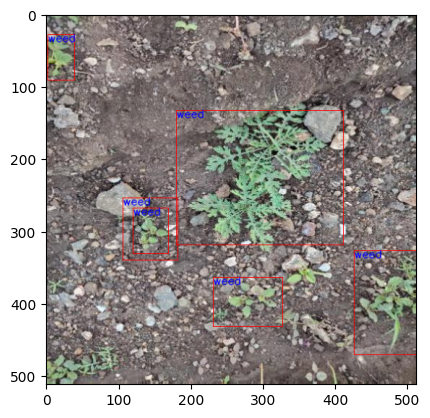

In [ ]:
def pipe_FRCN(img_pth):
    model.eval()
    names = {'0': 'crop', '1': 'weed'}
    src_img = plt.imread(img_pth)
    img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()

    out = model(torch.unsqueeze(img_tensor,dim=0))
    boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
    labels = out[0]['labels'].cpu().detach().numpy()
    scores = out[0]['scores'].cpu().detach().numpy()
    Names = []
    Boxes =[]
    for idx in range(boxes.shape[0]):
        if scores[idx] >= 0.8:
            x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
          #Boxes.append((x1+x2)/2,(y1+y2)/2)


            name = names.get(str(labels[idx].item()))
            cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,0,0),thickness=1)
            cv2.putText(src_img, text=name, org=(x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
            Names.append(name)


    if "weed" in Names:
        print(1)

        # return 1
    else:
        print(0)
        # return 0

    #print(Boxes)
    plt.imshow(src_img)



#pipe_FRCN(path + '/'+dir_list[2])
pipe_FRCN("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_76.jpeg")



    #print(Names)

0


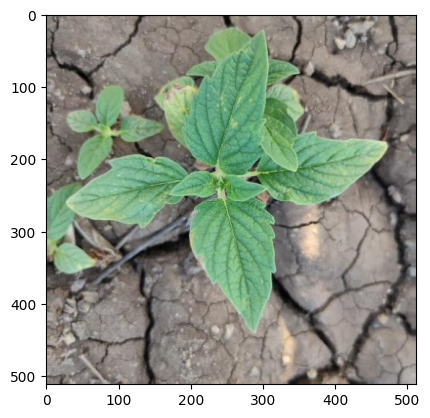

In [ ]:
pipe_FRCN("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_57.jpeg")


1


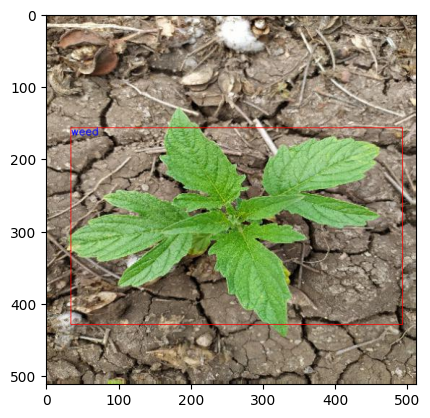

In [ ]:
pipe_FRCN("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_3.jpeg")

## FINAL ON RETINA

1


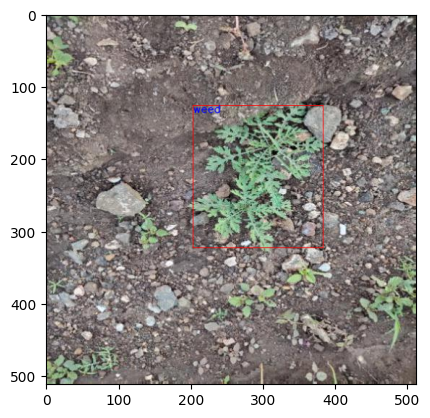

In [ ]:
def pipe_retina(img_pth):
    model_retina.eval()
    names = {'0': 'crop', '1': 'weed'}
    src_img = plt.imread(img_pth)
    img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()

    out = model_retina(torch.unsqueeze(img_tensor,dim=0))
    boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
    labels = out[0]['labels'].cpu().detach().numpy()
    scores = out[0]['scores'].cpu().detach().numpy()
    Names = []
    Boxes =[]
    for idx in range(boxes.shape[0]):
        if scores[idx] >= 0.8:
            x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
          #Boxes.append((x1+x2)/2,(y1+y2)/2)


            name = names.get(str(labels[idx].item()))
            cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,0,0),thickness=1)
            cv2.putText(src_img, text=name, org=(x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
            Names.append(name)


    if "weed" in Names:
        print(1)

        # return 1
    else:
        print(0)
        # return 0

    #print(Boxes)
    plt.imshow(src_img)



#pipe_retina(path + '/'+dir_list[2])
pipe_retina("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_76.jpeg")



    #print(Names)

0


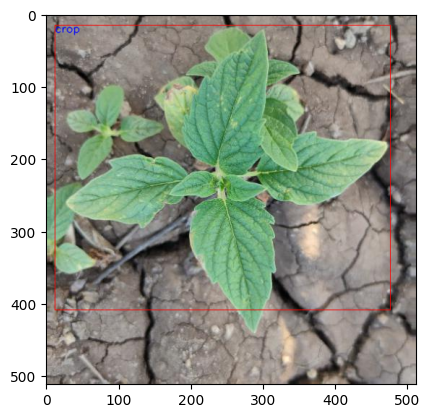

In [ ]:
pipe_retina("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_57.jpeg")

## FINAL SSD

1


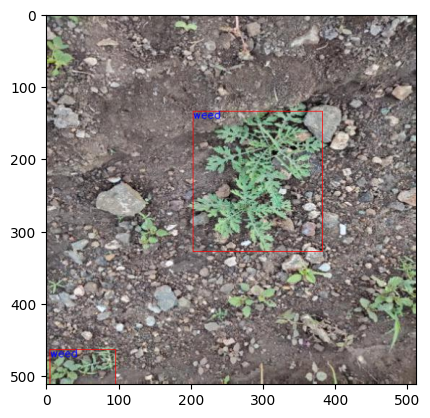

In [ ]:
def pipe_SSD(img_pth):
    model_SSD.eval()
    names = {'0': 'crop', '1': 'weed'}
    src_img = plt.imread(img_pth)
    img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()

    out = model_SSD(torch.unsqueeze(img_tensor,dim=0))
    boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
    labels = out[0]['labels'].cpu().detach().numpy()
    scores = out[0]['scores'].cpu().detach().numpy()
    Names = []
    Boxes =[]
    for idx in range(boxes.shape[0]):
        if scores[idx] >= 0.8:
            x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
          #Boxes.append((x1+x2)/2,(y1+y2)/2)


            name = names.get(str(labels[idx].item()))
            cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,0,0),thickness=1)
            cv2.putText(src_img, text=name, org=(x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
            Names.append(name)


    if "weed" in Names:
        print(1)

        # return 1
    else:
        print(0)
        # return 0

    #print(Boxes)
    plt.imshow(src_img)



#pipe_SSD(path + '/'+dir_list[2])
pipe_SSD("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_76.jpeg")



    #print(Names)

1


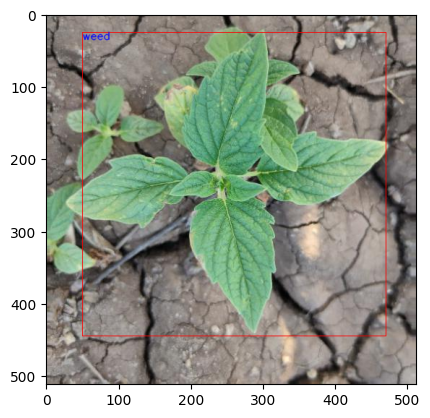

In [ ]:
pipe_SSD("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_57.jpeg")

1


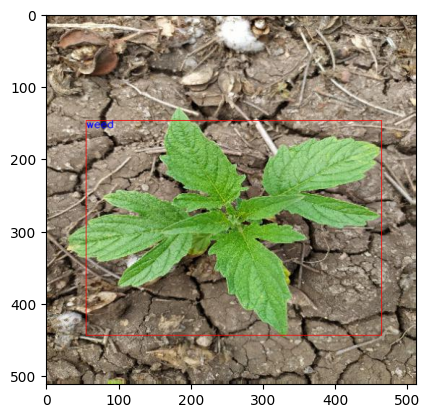

In [ ]:
pipe_SSD("/content/gdrive/MyDrive/Kaggle/agri_data/data/agri_0_3.jpeg")

## GOOGLE COLAB CAMERA PIC

In [ ]:
# # import the opencv library
# import cv2
# from google.colab.patches import cv2_imshow


# # define a video capture object
# vid = cv2.VideoCapture(0)

# while(True):

#     # Capture the video frame
#     # by frame
#     ret, frame = vid.read()

#     # Display the resulting frame
#     cv2_imshow( frame)

#     # the 'q' button is set as the
#     # quitting button you may use any
#     # desired button of your choice
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # After the loop release the cap object
# vid.release()
# # Destroy all the windows
# cv2.destroyAllWindows()


In [ ]:
# # function to convert the JavaScript object into an OpenCV image
# def js_to_image(js_reply):
#   """
#   Params:
#           js_reply: JavaScript object containing image from webcam
#   Returns:
#           img: OpenCV BGR image
#   """
#   # decode base64 image
#   image_bytes = b64decode(js_reply.split(',')[1])
#   # convert bytes to numpy array
#   jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
#   # decode numpy array into OpenCV BGR image
#   img = cv2.imdecode(jpg_as_np, flags=1)

#   return img

# # function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
# def bbox_to_bytes(bbox_array):
#   """
#   Params:
#           bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
#   Returns:
#         bytes: Base64 image byte string
#   """
#   # convert array into PIL image
#   bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
#   iobuf = io.BytesIO()
#   # format bbox into png for return
#   bbox_PIL.save(iobuf, format='png')
#   # format return string
#   bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

#   return bbox_bytes

In [ ]:
# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode

# def take_photo(filename='photo1.jpg', quality=0.8):
#   js = Javascript('''
#     async function takePhoto(quality) {
#       const div = document.createElement('div');
#       const capture = document.createElement('button');
#       capture.textContent = 'Capture';
#       div.appendChild(capture);

#       const video = document.createElement('video');
#       video.style.display = 'block';
#       const stream = await navigator.mediaDevices.getUserMedia({video: true});

#       document.body.appendChild(div);
#       div.appendChild(video);
#       video.srcObject = stream;
#       await video.play();

#       // Resize the output to fit the video element.
#       google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

#       // Wait for Capture to be clicked.
#       await new Promise((resolve) => capture.onclick = resolve);

#       const canvas = document.createElement('canvas');
#       canvas.width = video.videoWidth;
#       canvas.height = video.videoHeight;
#       canvas.getContext('2d').drawImage(video, 0, 0);
#       stream.getVideoTracks()[0].stop();
#       div.remove();
#       return canvas.toDataURL('image/jpeg', quality);
#     }
#     ''')
#   display(js)

#    # get photo data
#   data = eval_js('takePhoto({})'.format(quality))
#   # get OpenCV format image
#   img = js_to_image(data)

#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()
#   out = model(torch.unsqueeze(img_tensor,dim=0))
#   boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
#   labels = out[0]['labels'].cpu().detach().numpy()
#   scores = out[0]['scores'].cpu().detach().numpy()
#   Names = []
#   Boxes =[]
#   for idx in range(boxes.shape[0]):
#       if scores[idx] >= 0.8:
#           x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
#         #Boxes.append((x1+x2)/2,(y1+y2)/2)


#           name = names.get(str(labels[idx].item()))
#           cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,0,0),thickness=1)
#           cv2.putText(src_img, text=name, org=(x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#               fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
#           Names.append(name)


#   if "weed" in Names:
#       print(1)

#       # return 1
#   else:
#       print(0)
#       # return 0

#   #print(Boxes)
#   plt.imshow(img)






#   # data = eval_js('takePhoto({})'.format(quality))
#   # binary = b64decode(data.split(',')[1])
#   # with open(filename, 'wb') as f:
#   #   f.write(binary)
#   return filename

In [ ]:
# from IPython.display import Image
# try:
#   filename = take_photo()
#   print('Saved to {}'.format(filename))

#   # Show the image which was just taken.
#   display(Image(filename))
# except Exception as err:
#   # Errors will be thrown if the user does not have a webcam or if they do not
#   # grant the page permission to access it.
#   print(str(err))

## GOOGLE COLAB CAMERA LIVE STREAM

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<IPython.core.display.Javascript object>

0
0
0
0


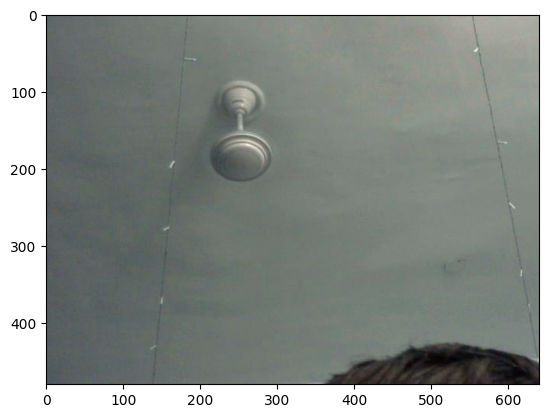

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # # get face region coordinates
    # faces = face_cascade.detectMultiScale(gray)
    # # get face bounding box for overlay

    names = {'0': 'crop', '1': 'weed'}
    src_img = img
    img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()

    out = model(torch.unsqueeze(img_tensor,dim=0))
    boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
    labels = out[0]['labels'].cpu().detach().numpy()
    scores = out[0]['scores'].cpu().detach().numpy()
    Names = []
    Boxes =[]
    for idx in range(boxes.shape[0]):
        if scores[idx] >= 0.8:
            x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]

            name = names.get(str(labels[idx].item()))
            cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,0,0),thickness=1)
            cv2.putText(src_img, text=name, org=(x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
            Names.append(name)


    if "weed" in Names:
        print(1)

        # return 1
    else:
        print(0)
        # return 0

    #print(Boxes)
    plt.imshow(src_img)












    # for (x,y,w,h) in faces:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    # bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # # update bbox so next frame gets new overlay
    # bbox = bbox_bytes

## STREAM LIT

In [ ]:
import pickle
pickle_out = open("model.pkl", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [ ]:
!pip install streamlit

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
import streamlit as st

Custom TB Handler failed, unregistering


In [ ]:
# WEBCAM TO TAKE PICS

%%writefile app.py
import streamlit as st
import pickle


import cv2
import numpy as np

img_file_buffer = st.camera_input("Take a picture")

if img_file_buffer is not None:
    # To read image file buffer with OpenCV:
    bytes_data = img_file_buffer.getvalue()
    cv2_img = cv2.imdecode(np.frombuffer(bytes_data, np.uint8), cv2.IMREAD_COLOR)



pickle_in = open('model.pkl', 'rb')
model = pickle.load(pickle_in)

def prediction(cv2_img):
  names = {'0': 'crop', '1': 'weed'}
  img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)

  img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()

  out = model(torch.unsqueeze(img_tensor,dim=0))
  boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
  labels = out[0]['labels'].cpu().detach().numpy()
  scores = out[0]['scores'].cpu().detach().numpy()
  # Names = []
  # Boxes =[]
  for idx in range(boxes.shape[0]):
      if scores[idx] >= 0.8:
          x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        #Boxes.append((x1+x2)/2,(y1+y2)/2)


          name = names.get(str(labels[idx].item()))
          cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,0,0),thickness=1)
          cv2.putText(src_img, text=name, org=(x1, y1+10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
              fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
          Names.append(name)


  if "weed" in Names:
      #print(1)
      st.write('1')

      # return 1
  else:
      #print(0)
      st.write('0')




    # Check the type of cv2_img:
    # Should output: <class 'numpy.ndarray'>
    #st.write(type(cv2_img))

    # Check the shape of cv2_img:
    # Should output shape: (height, width, channels)
    #st.write(cv2_img.shape)

Overwriting app.py


In [ ]:
# %%writefile app.py

# import streamlit as st
# import pickle
# import cv2
# import numpy as np
# import torch

# pickle_in = open('model.pkl', 'rb')
# model = pickle.load(pickle_in)

# def prediction(cv2_img):
#     names = {'0': 'crop', '1': 'weed'}
#     img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
#     img_tensor = torch.from_numpy(img / 255.).permute(2, 0, 1).float().cuda()
#     out = model(torch.unsqueeze(img_tensor, dim=0))
#     boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
#     labels = out[0]['labels'].cpu().detach().numpy()
#     scores = out[0]['scores'].cpu().detach().numpy()
#     Names = []
#     for idx in range(boxes.shape[0]):
#         if scores[idx] >= 0.8:
#             x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
#             name = names.get(str(labels[idx].item()))
#             cv2.rectangle(cv2_img, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
#             cv2.putText(cv2_img, text=name, org=(x1, y1 + 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#                         fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
#             Names.append(name)

#     if "weed" in Names:
#         st.write('1')
#     else:
#         st.write('0')

# st.title('Webcam Image Classification')
# st.write("Click 'Take a picture' to capture an image from your webcam.")

# img_file_buffer = st.camera_input("Take a picture")

# if img_file_buffer is not None:
#     # To read image file buffer with OpenCV:
#     bytes_data = img_file_buffer.getvalue()
#     cv2_img = cv2.imdecode(np.frombuffer(bytes_data, np.uint8), cv2.IMREAD_COLOR)
#     prediction(cv2_img)
#     st.image(cv2_img, channels="BGR")


Overwriting app.py


In [ ]:

# %%writefile app.py

import streamlit as st
import pickle
import cv2
import numpy as np
import torch

pickle_in = open('model.pkl', 'rb')
model = pickle.load(pickle_in)

def prediction(cv2_img):
    names = {'0': 'crop', '1': 'weed'}
    img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img / 255.).permute(2, 0, 1).float().cuda()
    out = model(torch.unsqueeze(img_tensor, dim=0))
    boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
    labels = out[0]['labels'].cpu().detach().numpy()
    scores = out[0]['scores'].cpu().detach().numpy()
    Names = []
    for idx in range(boxes.shape[0]):
        if scores[idx] >= 0.8:
            x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
            name = names.get(str(labels[idx].item()))
            cv2.rectangle(cv2_img, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
            cv2.putText(cv2_img, text=name, org=(x1, y1 + 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.5, thickness=1, lineType=cv2.LINE_AA, color=(0, 0, 255))
            Names.append(name)

    if "weed" in Names:
        st.write('1')
    else:
        st.write('0')

st.title('Webcam Image Classification')
st.write("Live output from webcam feed.")


# Initialize video capture object
#cap = cv2.VideoCapture(0)
cap = st.video_input("Take a video")


# Check if the webcam is opened correctly
if not cap.isOpened():
    st.error("Cannot access the webcam.")
else:
    # Read and display frames from the webcam
    while True:
        ret, frame = cap.read()
        if not ret:
            st.error("Cannot receive frame (stream end?). Exiting...")
            break

        # Process frame for prediction
        prediction(frame)

        # Display the frame with processed output
        st.image(frame, channels="BGR", use_column_width=True)

        # Check for user input to stop the stream
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()



Overwriting app.py


In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 43.0 MB/s eta 0:00:00


In [ ]:
import av
import cv2
import time
import streamlit as st
from pyzbar.pyzbar import decode
from streamlit_webrtc import (webrtc_streamer, VideoProcessorBase,WebRtcMode)
import numpy as np
import torch



In [ ]:
# !npm install localtunnel

In [ ]:
!wget -q -O - https://loca.lt/mytunnelpassword

34.126.141.182

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501


npx: installed 22 in 2.755s
your url is: https://lemon-shirts-turn.loca.lt
^C
